# Cellpose Segmentation and GFP dot counting

#### Install Python Modules 


In [ ]:
# !pip install numpy
# !pip install nd2reader
# !pip install scikit-image==0.19.1
# !pip install cellpose
# !pip install pandas
# !pip install glob2
# !pip install os-sys
# !pip install matplotlib
! pip install psutil

##### Import Python Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nd2reader import ND2Reader
from skimage.exposure import rescale_intensity
from cellpose import models
from skimage.segmentation import mark_boundaries
from skimage.filters import gaussian
from skimage.morphology import disk,white_tophat,disk,remove_small_objects
from skimage.measure import label,regionprops_table
import pandas as pd
import os
import psutil

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


2022-04-27 11:30:48,922 [INFO] WRITING LOG OUTPUT TO /Users/robertwelch/.cellpose/run.log
2022-04-27 11:30:50,079 [INFO] NumExpr defaulting to 8 threads.


#### Define Script Functions

In [8]:
#Used to find max intensity projection of ND2 stack for cytoplasm and nuclei channels
def nd2_max_projection(nd2_object):
    #Get frame dimensions
    Z_DIM = nd2_object.sizes['z']
    X_DIM = nd2_object.frame_shape[0]
    Y_DIM = nd2_object.frame_shape[1]
    stack = np.empty([Z_DIM,X_DIM,Y_DIM])

    #Import all cytoplasm focal planes
    nd2_object.default_coords['c'] = 0 #Cyto Channel
    for z in range(Z_DIM):
        stack[z,:,:] = nd2_object[z]

    #Calculate maximum intensity projects for cyto channel
    max_intensity_cyto = np.amax(stack,axis=(0))

    #Import all nuclei focal planes
    nd2_object.default_coords['c'] = 1 #Nuclei Channel
    for z in range(Z_DIM):
        stack[z,:,:] = nd2_object[z]

    #Calculate maximum intensity projects for nuclei channel
    max_intensity_nuclei = np.amax(stack,axis=(0))

    return max_intensity_cyto,max_intensity_nuclei

#Used to import ND2 image stacks and return max, intensity projection of cytoplasm and nuclei channels
def import_stack(img_path,focal_plane_cyto=0,focal_plane_nuclei=0,min_percentile_cyto = 0,
                 max_percentile_cyto = 100,min_percentile_nuclei = 0,max_percentile_nuclei = 100,
                 max_intensity_projection = None):

  #Open ND2 file as object
    with ND2Reader(img_path) as nd2_object:

  #If we want maximum projection images
        if max_intensity_projection is True:
            channel_cyto,channel_nuclei = nd2_max_projection (nd2_object)

    #If we want any focal plane
        else:
            #Import cytoplasm image at desired focal plane
            nd2_object.default_coords['c'] = 0
            channel_cyto = nd2_object[focal_plane_cyto]

            #Import nuclei image at desired focal plane
            nd2_object.default_coords['c'] = 1
            channel_nuclei = nd2_object[focal_plane_nuclei]

    channel_cyto_no_saturation =  channel_cyto

    #rescale cyto channel based on max and min cyto percentile limits
    v_min, v_max = np.percentile(channel_cyto, (min_percentile_cyto, max_percentile_cyto))
    channel_cyto = rescale_intensity(channel_cyto, in_range=(v_min, v_max))

    channel_nuclei_no_saturation = channel_nuclei

    #rescale nuclei channel based on max and min nuclei percentile limits
    v_min, v_max = np.percentile(channel_nuclei, (min_percentile_nuclei, max_percentile_nuclei))
    channel_nuclei = rescale_intensity(channel_nuclei, in_range=(v_min, v_max))

    #Create 3d array with with channel 0: cytoplasm, channel 1: nuclei
    output_stack = np.zeros([3,channel_cyto.shape[0],channel_cyto.shape[1]])
    output_stack[1,:,:] = channel_cyto
    output_stack[2,:,:] = channel_nuclei

    #Create 3d array with with channel 0: cytoplasm, channel 1: nuclei
    output_stack_no_saturation = np.zeros([3,channel_cyto.shape[0],channel_cyto.shape[1]])
    output_stack_no_saturation[1,:,:] = channel_cyto_no_saturation
    output_stack_no_saturation[2,:,:] = channel_nuclei_no_saturation

    #Convert to float32 for cellpose
    output_stack = (output_stack).astype(dtype = 'float32') 
    output_stack_no_saturation = (output_stack_no_saturation/65535.0).astype(dtype = 'float32')

    return output_stack,output_stack_no_saturation


#Segments the nucleus. Pass the 3D image stack and choose manual segmentation threshold for nuclei
def nuclei_segmentation(stack,thresh_nuclei=0.06,show_results = None):
    #Blur nuclei image
    nuclei_image = gaussian(stack[2,:,:],1)

    mask_nuclei = ((nuclei_image > thresh_nuclei)*1).astype('float32')
    
    if show_results is True:
        plt.figure(figsize = (20,5))
        plt.subplot(1,2,1)
        plt.imshow(stack[2,:,:])
        plt.title('Nuclei Channel')
        plt.colorbar()

        plt.subplot(1,2,2)
        plt.imshow(mask_nuclei)
        plt.title('Nuclei Channel')
    return mask_nuclei

#Segments the nucleus. Pass the 3D image stack and run cellpose for nuclei
def nuclei_segmentation_cellpose(stack,diameter = 80,flow_threshold = 0,use_gpu = False,
                                 show_results = None):
    #Blur nuclei image
    nuclei_image = gaussian(stack[2,:,:],1)

    # Lowered Batch_size from default 8 to reduce memory requirements
    model = models.Cellpose(gpu=use_gpu, model_type='nuclei',net_avg=False)
    mask_nuclei, _, _, _ = model.eval(nuclei_image,batch_size = 4, diameter = diameter,
                                      flow_threshold=flow_threshold, channels=[0,0])
    
    if show_results is True:
        plt.figure(figsize = (20,5))
        plt.subplot(1,2,1)
        plt.imshow(stack[2,:,:])
        plt.title('Nuclei Channel')
        plt.colorbar()

        plt.subplot(1,2,2)
        plt.imshow(mask_nuclei)
        plt.title('Nuclei Channel')
    return mask_nuclei

#Function to segment the cells using Cellpose
def cell_segmentation(stack,diameter = 200,flow_threshold = 0,use_gpu = False,show_results = False):

    model = models.Cellpose(gpu=use_gpu, model_type='cyto',net_avg=False)

    # Lowered Batch_size from default 8 to reduce memory requirements
    mask_cyto, _, _, _ = model.eval(stack,batch_size = 4, diameter=diameter, 
                                    flow_threshold=flow_threshold, channels=[2,3])

    if show_results == True:
        plt.figure(figsize = (15,15))
        segmentation_results = mark_boundaries(stack[1,:,:],mask_cyto)
        plt.imshow(segmentation_results)

    return mask_cyto


#Function to segment LC3 dots using white tophot and manual thresholding
def LC3_segmentation(stack,mask,threshold,tophat_size = 5,
                     minimum_dot_size = 0,display_results = False):
    #mask: cytoplasm mask (no nuclei)
    
    #Use cyto channel
    image = stack[1,:,:]

    #Smooth image
    image_guassian = gaussian(image,1)

    #Tophat morphological filter to supress large objects in image
    LC3_tophat = white_tophat(image_guassian,disk(tophat_size))

    #Manual Thresholding
    LC3_segmented = LC3_tophat > threshold   

    #Remove nuclei + out-of-cell dots
    LC3_segmented = LC3_segmented * mask

    #Removes dots below specified area if needed
    if minimum_dot_size > 0 :
        LC3_segmented = remove_small_objects(np.bool_(LC3_segmented),min_size = minimum_dot_size)

    #Show overlayed image if needed
    if display_results == True:
        
        segmentation_results = mark_boundaries(stack[1,:,:],np.bool_(LC3_segmented))
        plt.figure(figsize= (10,10))
        plt.imshow(segmentation_results)         
    return np.uint16(LC3_segmented)

#### User Inputs



In [9]:
#1. Enter the filepath of the folder containing the images to analyze
folder_path = '/Users/robertwelch/Desktop/SciLifeLab/BIIF_Projects/Chiara Project - GFP Dot Counting/Cropped_multi_folder_test' #IF USING A PC: add r before string ie. r'/Users/robertwelch/Desktop/' instead of '/Users/robertwelch/Desktop/'

#2. Run cell segmentation with GPU?:
use_gpu = True # if available, set to: True. Will automatically use CPU if no GPU is found.

#3. Most Important Parameters to tune - LC3+ Detection parameters 
threshold_LC3 = 0.08 # Intensity threshold (Larger value results in less dots). Typical range: 0.03 - 0.2
minimum_dot_size = 10 # The minimum pixel area for a dot to be detected. Likely ~3-15
tophat_size = 4 # White tophat size

#4. Cellpose parameters, useful only if cellular segmentation is failing
cell_diameter = 200 #Estimate of cell_diamter [pixels] - I find ~200 works well and is faster, despite being an overestimate
flow_threshold_cyto = 0 # decrease if cell segmentation if missing cells (usually around 0-0.9)

#Nuclei Segmentation
method = 'CELLPOSE' #set to 'CELLPOSE' or 'GLOBAL'. CELLPOSE is more robust to nuclei saturation but slower.

#5. GLOBAL Nuclei Segmentation, adjust if method = 'GLOBAL'
nuclei_threshold = 0.06 #Threshold for nuclei segmentation.

#6. CELLOPOSE Nuclei Segmentation, adjust parameters if using 'CELLPOSE' method
nuclei_diameter = 35 #estimate of nuclei_diameter in pixels
nuclei_flow = 0 #decrease if cell segmentation if missing cells (usually around 0-0.9)

#7. Image Export resolution
output_images = True #True or False. If True, will save segmentation images in Results folder. Will slow down processing.
resolution = 200 #pixels per inch. Higher resolution will result in slower processing and greater storage requirements.

##### Run Program

In [10]:
def find_image_paths(folder_path):
    image_paths = []
    image_roots = []
    for root, _, files in os.walk(folder_path):
        for name in files:
            if name.endswith('.nd2'):
                image_paths.append(os.path.join(root,name))
                image_roots.append(root)
    return image_paths, image_roots

image_paths,image_roots = find_image_paths(folder_path)

counter = 0 

#Loop to anaylyze all images
for counter in range(len(image_paths)):
    print('Before')
    print(psutil.cpu_percent())
    print(psutil.virtual_memory())  # physical memory usage
    print('memory % used:', psutil.virtual_memory()[2])

    image_path = image_paths[counter]
    image_root = image_roots[counter]

    print('Images Analyzed:',counter,'out of',len(image_paths))
    print('Analyzing:',image_path)

    


    #Open Max Intensity Projection Image stack with formatting for cellpose
    #stack_with_sat has cytoplasm channel clipped to 95% max intensity, stack_without_sat does not
    stack_with_sat,stack_without_sat = import_stack(image_path,min_percentile_cyto=0,max_percentile_cyto=95,
                                                min_percentile_nuclei=0,max_percentile_nuclei=100,max_intensity_projection=True)

    #Create Nuclei Mask
    if method == 'CELLPOSE':
        mask_nuclei = nuclei_segmentation_cellpose(stack_with_sat,diameter = nuclei_diameter,flow_threshold=nuclei_flow,use_gpu = use_gpu,show_results = False)
    elif method == 'GLOBAL':
        mask_nuclei = nuclei_segmentation(stack_with_sat,thresh_nuclei=nuclei_threshold,show_results=False)
    else:
        print('Nuclei Method not chosen correctly - enter as CELLPOSE or GLOBAL')
        break
      
    #Create Cell Mask
    mask_cyto = cell_segmentation(stack_with_sat,diameter = cell_diameter,flow_threshold=flow_threshold_cyto,use_gpu = use_gpu,show_results = False)

    #Create cell mask with no nuclei
    net_mask = ((mask_cyto>0) - mask_nuclei)>0   

    #Segment the LC3+ dots
    LC3_segmented = LC3_segmentation(stack_with_sat,net_mask,threshold = threshold_LC3,
                                    minimum_dot_size=minimum_dot_size,display_results=False,tophat_size=tophat_size)
    labeled_LC3 = label(LC3_segmented)

    #Identify with cell LC3+ proteins appear in
    props = regionprops_table(labeled_LC3,mask_cyto,properties=('label','intensity_min'))

    #Convert regionprops results to pandas data frame and count number of LC3+ per cell
    data_holder = pd.DataFrame(props)
    data_holder = data_holder['intensity_min'].value_counts().reset_index()

    num_cells = np.amax(mask_cyto)
    num_cells_with_proteins = len(data_holder)
    cells_without_proteins = num_cells-num_cells_with_proteins
    
    # #Add zeros for segmented cells with no detectable LC3 dots
    zero_pad = pd.DataFrame(np.zeros([cells_without_proteins,2]),columns=data_holder.columns)
    proteins_in_each_cell = pd.concat([data_holder,zero_pad],ignore_index = True)
    proteins_in_each_cell = proteins_in_each_cell['intensity_min'] # Only output number of proteins, discard cell ID label
    proteins_in_each_cell = pd.DataFrame(proteins_in_each_cell) #Re-format to Dataframe object
    
    #Results header string - uses number tag before .nd2 at end of file name
    # if running on mac
    if os.name == 'posix':
        split_image_path = image_path.split('/')
    # If running on windows
    elif os.name == 'nt':
        split_image_path = image_path.split('\\')

    file_number = split_image_path[-1][:-4]
    header = ['LC3+ Count: Image {0}'.format(file_number)]

    #If First file, write an excel file to store excel results
    new_storage_directory = os.path.join(image_root,'Results')
    results_path = os.path.join(new_storage_directory,'LC3 Counts.xlsx')

    #Check if storage directory exits, if not make one
    if os.path.exists(new_storage_directory):
        pass  
    else:
        os.mkdir(new_storage_directory) 

    #create excel results file if it does not exist, otherwise write to existing
    if os.path.exists(results_path) is False:
        proteins_in_each_cell = proteins_in_each_cell.rename(columns={'intensity_min':header[0]})
        proteins_in_each_cell.to_excel(results_path,index = False,header = header[0])

    else:
        #Open Exisisting excel data and new write data to it
        existing_excel = pd.read_excel(results_path)
        new_excel = pd.concat([existing_excel,proteins_in_each_cell],axis = 1,ignore_index=False)
        new_excel = new_excel.rename(columns={'intensity_min':header[0]})
        new_excel.to_excel(results_path,index = False)

    #Save Tiff. Image of results
    if output_images is True:
        fig,ax = plt.subplots(1,3)
        fig.set_size_inches(20,20)
        
        image_name_tiff = split_image_path[-1].replace('.nd2','.tiff')

        ax[0].imshow(mark_boundaries(stack_with_sat[1,:,:],mask_cyto))
        ax[0].set_title('Cell Segmentation')
        #imsave(new_storage_directory+'/cell_'+image_name_tiff,mark_boundaries(stack_with_sat[1,:,:],mask_cyto))

        ax[1].imshow(mark_boundaries(stack_with_sat[2,:,:],label(mask_nuclei)))
        ax[1].set_title('Nuclei Segmentation')
        #imsave(new_storage_directory+'/nuclei_'+image_name_tiff,mark_boundaries(stack_with_sat[2,:,:],mask_nuclei.astype('uint16')))

        ax[2].imshow(mark_boundaries(stack_with_sat[1,:,:],labeled_LC3))
        ax[2].set_title('LC3 Detected')
        #imsave(new_storage_directory+'/LC3_'+image_name_tiff,mark_boundaries(stack_with_sat[1,:,:],labeled_LC3))

        #If you want to speed up significantly, reduce dpi (resolution of images or comment out saving image results)
        plt.tight_layout()
        plt.savefig(os.path.join(new_storage_directory+'results-{0}.tiff'.format(file_number)),dpi = resolution)
        plt.close('all')
        
        print('After')
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        print('memory % used:', psutil.virtual_memory()[2])
        
print('Finished, all images analyzed.')

Finished, all images analyzed.


Memory usage (in chunks of .1 seconds): [1130.3671875, 1129.6328125, 1272.8359375, 1470.42578125, 1553.5390625, 1667.8671875]
Maximum memory usage: 1667.8671875


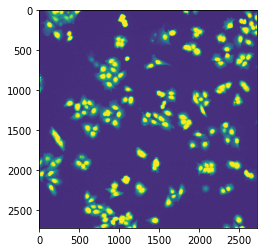

In [20]:
from memory_profiler import memory_usage
import gc
def test():
    img = stack_with_sat[1,:,:]
    for i in range(25):
        plt.imshow(img)
        fig.clf()
        plt.close() 
        gc.collect()    

mem_usage = memory_usage(test)
print('Memory usage (in chunks of .1 seconds): %s' % mem_usage)
print('Maximum memory usage: %s' % max(mem_usage))